In [1]:
%load_ext autoreload
%autoreload 2

In [64]:
import sys
import pathlib

PROJECT_ROOT = pathlib.Path().cwd().parent
sys.path.append(str(PROJECT_ROOT))

image_path = PROJECT_ROOT / 'ReMIND2Reg_dataset' / 'imagesTr'

from src.utils import *
from src.impedance import *
from src.datatype import MRIDataset, iUSDataset
from src.renderer import *
from src.cone import *
from src.impedance import ImpedanceEstimator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.cluster import KMeans
import cv2

print(torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

2.7.1+cu126
CUDA available: True
CUDA version: 12.6
GPU name: NVIDIA GeForce GTX 1650


In [109]:
patient_id = "003" # between 000 and 102, t1 and t2 don't exist for all patients
iUS_file = f"ReMIND2Reg_0{patient_id}_0000.nii.gz"
t1_file = f"ReMIND2Reg_0{patient_id}_0001.nii.gz"
t2_file = f"ReMIND2Reg_0{patient_id}_0002.nii.gz"

# Load with nibabel; each img is a Nifti1Image object
us_img = nib.load(str(image_path / iUS_file))
t1_img = nib.load(str(image_path / t1_file))
t2_img = nib.load(str(image_path / t2_file))

# Extract data arrays (as NumPy) and affines
US_vol = us_img.get_fdata(dtype=np.float32)
US_affine = us_img.affine
T1_vol = t1_img.get_fdata(dtype=np.float32)
T1_affine = t1_img.affine
T2_vol = t2_img.get_fdata(dtype=np.float32)
T2_affine = t2_img.affine

# Preliminary computations

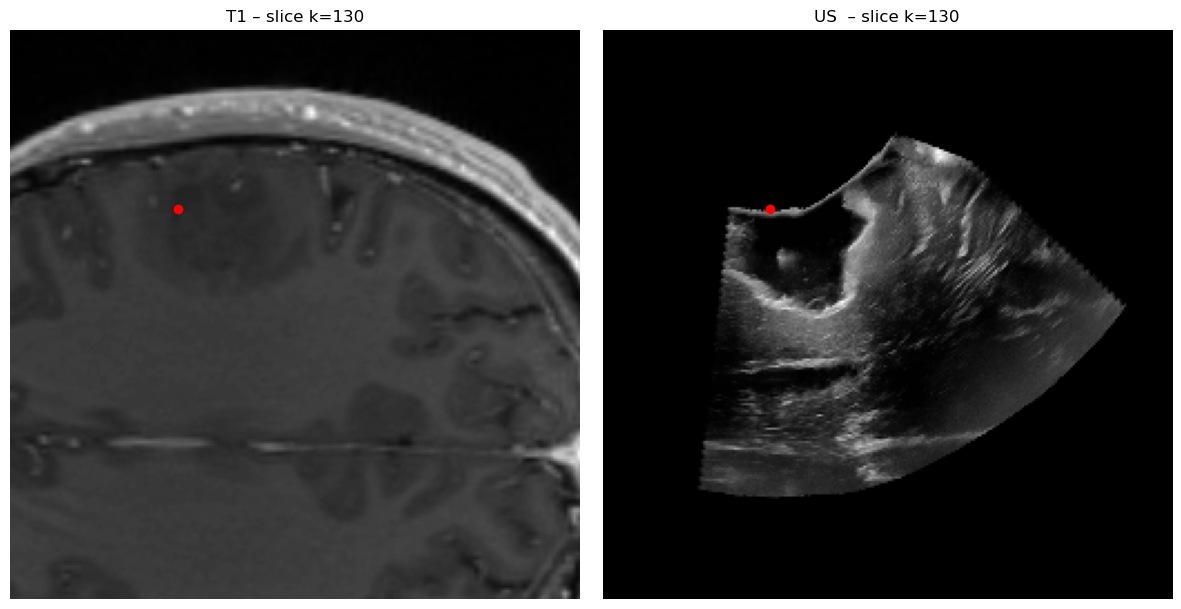

In [4]:
i_mri, j_mri, slice_idx = 175, 75, 130 # Example indices for T1 MRI
us_slice, us_idx = mri_to_us_point(i_mri, j_mri, slice_idx, T1_vol, T1_affine, US_vol, US_affine)
plot_mri_us_aligned(i_mri, j_mri, slice_idx, T1_vol, us_slice, us_idx)

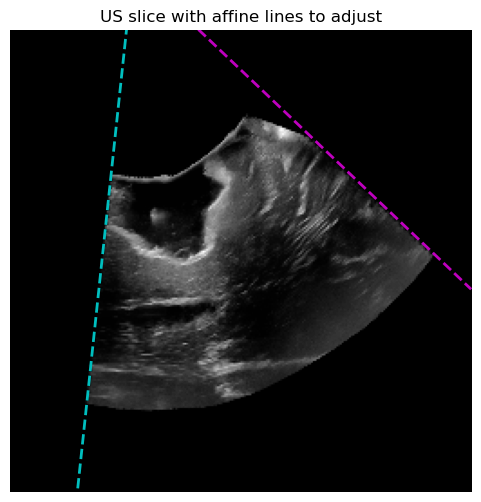

In [5]:
# US edges parameters
mL, bL = 9.4, -350  # Left edge line parameters (slope, intercept)
mR, bR = -0.9524, 355  # Right edge line parameters (slope, intercept)
# mL, bL = -0.1, 216
# mR, bR = 1.05, -117
plot_us_with_affine_lines(us_slice, mL, bL, mR, bR)

_, _, k_us = us_idx
H_us, W_us = us_slice.shape

In [6]:
cone_params = compute_us_apex_and_direction(mL, bL, mR, bR)
x0, y0 = cone_params["apex"]
print("Source :", (x0, y0))
opening_angle   = cone_params["opening_angle"]
direction_vec   = cone_params["direction_vector"]

Source : (68.10015068969514, 290.1414164831343)


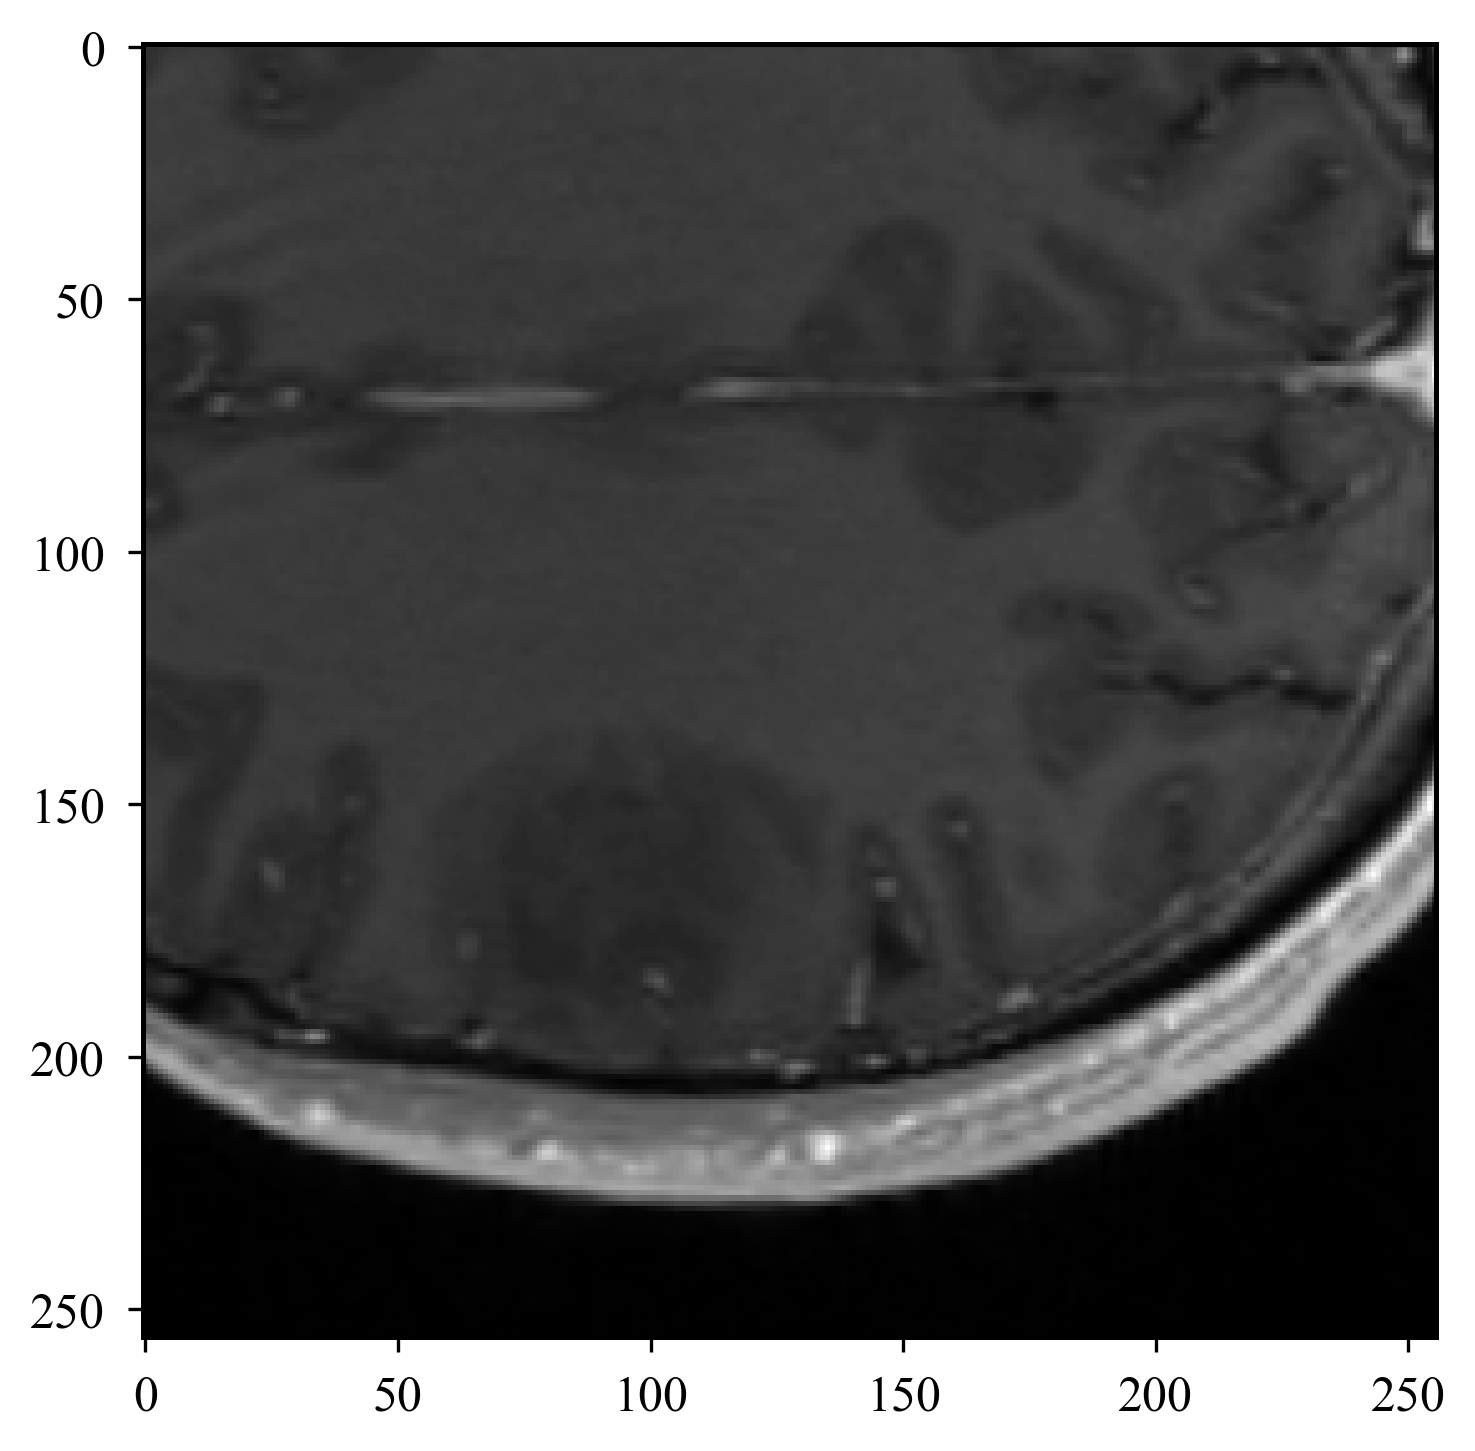

In [20]:
plt.imshow(Z_vol[:,:,slice_idx], cmap='gray')

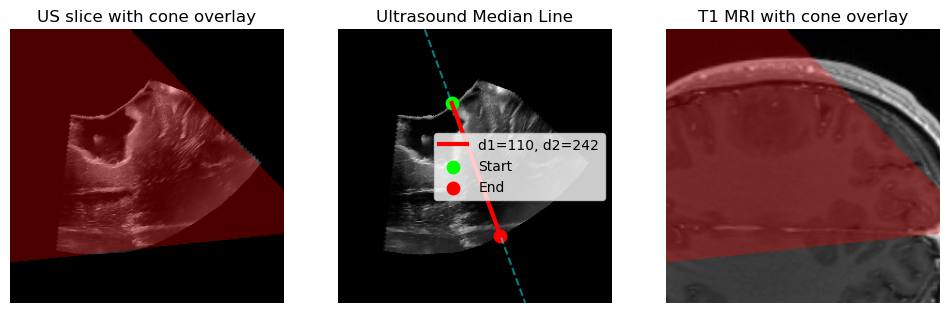

In [7]:
mask_us = overlay_cone(us_slice, apex=np.array([x0, y0]), direction_vector=direction_vec, opening_angle=opening_angle)
fig, ax = plt.subplots(1,3, figsize=(12, 6))
plot_overlay_cone(us_slice, mask_us, ax=ax[0])
plot_median_line(us_slice, cone_params["apex"], cone_params["direction_vector"], d1=110, d2=242, ax=ax[1])

t1_slice = T1_vol[:, :, slice_idx]
H_t1, W_t1 = t1_slice.shape
apex_us_vox = np.array([x0, y0, k_us])

apex_mri_world, direction_mri_world = cone_us_to_mri_world(apex_us_vox, direction_vec, US_affine, T1_affine)

# Visualize result
mask_mri = overlay_cone(t1_slice, apex=apex_mri_world[:2], direction_vector=direction_mri_world, opening_angle=opening_angle)
plot_overlay_cone(t1_slice, mask_mri, ax=ax[2], title="T1 MRI with cone overlay")

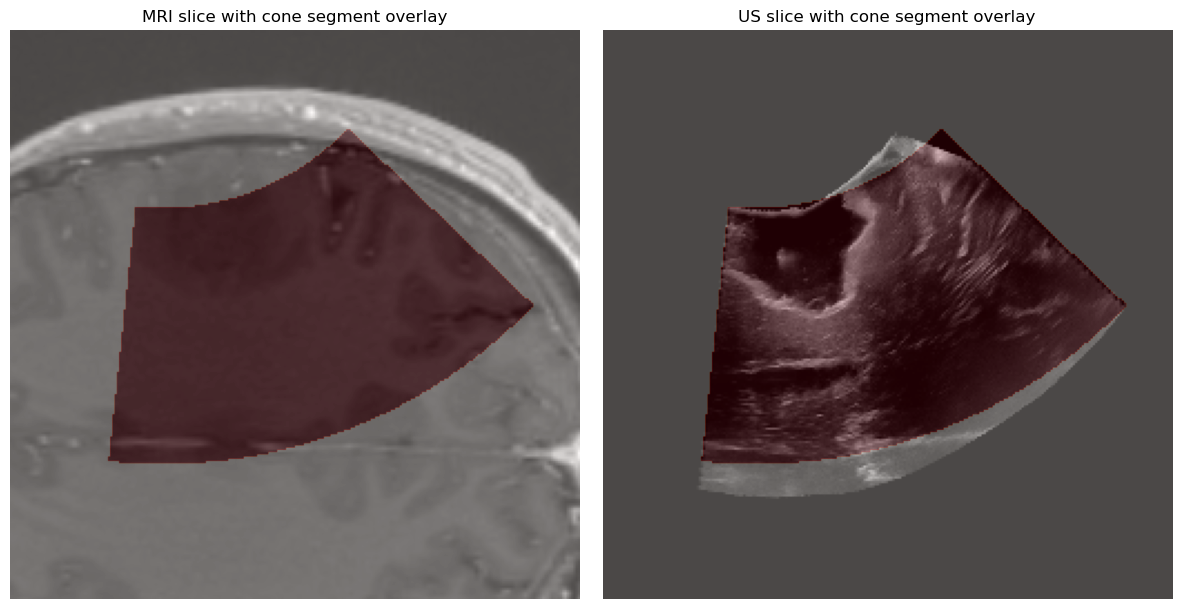

In [8]:
import numpy as np

def depr_mask_cone_segment(mask, apex, direction, d1, d2):
    """
    Keep only the part of the cone between distances d1 and d2 from the apex along the median direction.
    mask: 2D boolean array (the cone mask)
    apex: (x0, y0) coordinates (float)
    direction: (dx, dy) unit vector (float)
    d1, d2: distances from apex (float)
    Returns: new mask (bool)
    """
    H, W = mask.shape
    x0, y0 = apex
    dx, dy = direction / np.linalg.norm(direction)
    # Create coordinate grid
    xx, yy = np.meshgrid(np.arange(W), np.arange(H))
    # Vector from apex to each point
    vx = xx - x0
    vy = yy - y0
    # Project each point onto the median direction
    proj = vx * dx + vy * dy
    # Keep only points between d1 and d2
    segment_mask = (proj >= d1) & (proj <= d2)
    return mask & segment_mask

#rounded version
def mask_cone_segment(mask, apex, direction, d1, d2):
    """
    Keep only the part of the cone between distances d1 and d2 from the apex along the median direction,
    with rounded caps at d1 and d2.
    
    Parameters:
        mask: 2D boolean array (the cone mask)
        apex: (x0, y0) coordinates (float)
        direction: (dx, dy) unit vector (float)
        d1, d2: distances from apex (float)
        
    Returns:
        mask_segment: 2D boolean array with rounded cone segment
    """
    H, W = mask.shape
    x0, y0 = apex
    dx, dy = direction / np.linalg.norm(direction)
    # Coordinate grid
    xx, yy = np.meshgrid(np.arange(W), np.arange(H))
    # Vector from apex to each point
    vx = xx - x0
    vy = yy - y0
    # Project each point onto the median direction (how far along the cone axis)
    proj = vx * dx + vy * dy

    # Project each point onto the median direction
    proj = vx * dx + vy * dy

    # Calculate distance from apex to each point
    dist = np.sqrt(vx**2 + vy**2)
    # Create a mask for points within the rounded caps

    rounded_mask_d1 = dist >= d1
    rounded_mask_d2 = dist <= d2
    # Combine the masks
    mask = mask & (rounded_mask_d1 | rounded_mask_d2)
    return mask & rounded_mask_d1 & rounded_mask_d2


apex = apex_mri_world[:2]
direction = direction_mri_world[:2]
d1, d2 = 115, 230

mask_segment_mri = mask_cone_segment(mask_mri, apex, direction, d1, d2)
mask_segment_us = mask_cone_segment(mask_us, np.array([x0, y0]), direction_vec, d1, d2)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(t1_slice, cmap='gray', origin='lower')
axs[0].imshow(mask_segment_mri, cmap='Reds', alpha=0.3, origin='lower')
axs[0].set_title("MRI slice with cone segment overlay")
axs[0].axis('off')

axs[1].imshow(us_slice, cmap='gray', origin='lower')
axs[1].imshow(mask_segment_us, cmap='Reds', alpha=0.3, origin='lower')
axs[1].set_title("US slice with cone segment overlay")
axs[1].axis('off')

plt.tight_layout()
plt.show()


Looks like there is some issue here...

# Train MLP to find Z_vol (Acoustic Impedance)

In [54]:
def generate_cone_directions(direction_mri_world, opening_angle, n_rays):
    """
    Generate a fan of directions centered on direction_mri_world,
    spanning opening_angle (in radians), in the (x, y) plane (z=0).
    Returns: (n_rays, 3) tensor
    """
    # Normalize the median direction
    d = np.array(direction_mri_world[:2])
    d = d / np.linalg.norm(d)
    # Orthogonal vector in-plane
    ortho = np.array([-d[1], d[0]])
    # Angles from -half to +half opening
    angles = np.linspace(-opening_angle/2, opening_angle/2, n_rays)
    directions = []
    for a in angles:
        v = np.cos(a) * d + np.sin(a) * ortho
        directions.append([v[0], v[1], 0.0])
    return torch.tensor(directions, dtype=torch.float32)

In [12]:
n_rays = 64
source = torch.tensor(apex_mri_world)
directions = generate_cone_directions(direction_mri_world, opening_angle, n_rays)

us_real = us_slice
cone_mask = mask_segment_us

directions = generate_cone_directions(direction_mri_world, opening_angle, n_rays)
print(source, directions, np.degrees(opening_angle))

tensor([ 68.1002, 290.1414, 130.0000], dtype=torch.float64) tensor([[-0.1058, -0.9944,  0.0000],
        [-0.0913, -0.9958,  0.0000],
        [-0.0768, -0.9970,  0.0000],
        [-0.0623, -0.9981,  0.0000],
        [-0.0478, -0.9989,  0.0000],
        [-0.0333, -0.9994,  0.0000],
        [-0.0188, -0.9998,  0.0000],
        [-0.0042, -1.0000,  0.0000],
        [ 0.0103, -0.9999,  0.0000],
        [ 0.0248, -0.9997,  0.0000],
        [ 0.0394, -0.9992,  0.0000],
        [ 0.0539, -0.9985,  0.0000],
        [ 0.0684, -0.9977,  0.0000],
        [ 0.0829, -0.9966,  0.0000],
        [ 0.0974, -0.9952,  0.0000],
        [ 0.1118, -0.9937,  0.0000],
        [ 0.1263, -0.9920,  0.0000],
        [ 0.1407, -0.9901,  0.0000],
        [ 0.1550, -0.9879,  0.0000],
        [ 0.1694, -0.9856,  0.0000],
        [ 0.1837, -0.9830,  0.0000],
        [ 0.1980, -0.9802,  0.0000],
        [ 0.2122, -0.9772,  0.0000],
        [ 0.2264, -0.9740,  0.0000],
        [ 0.2405, -0.9707,  0.0000],
        [ 0.254

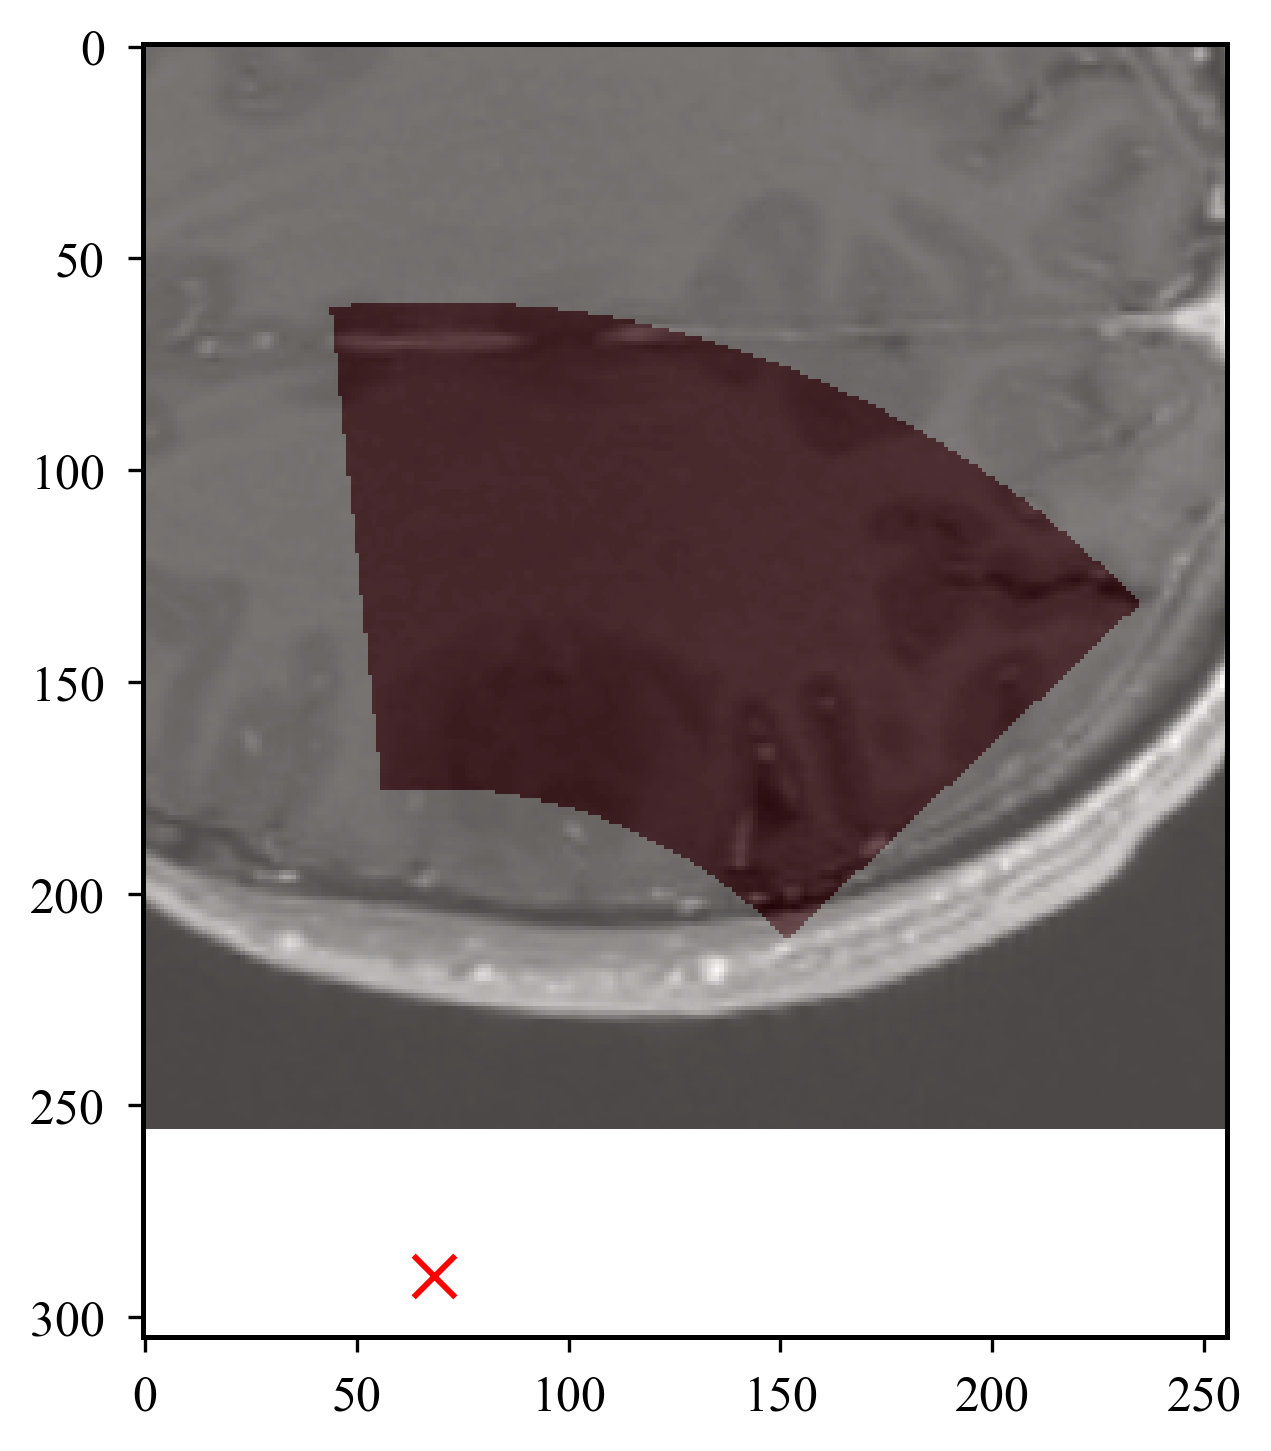

In [22]:
plt.imshow(Z_vol[:, :, 130], cmap='gray')
plt.imshow(mask_segment_mri, cmap='Reds', alpha=0.3)
plt.scatter(
    apex_mri_world[0], 
    apex_mri_world[1], 
    c='red', s=100, label='Apex', marker='x'
)


# REMASTERED 2

In [14]:
device = torch.device('cpu')
print(device)

cpu


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

# =====================
# Academic Plot Settings
# =====================
plt.style.use('seaborn-v0_8-paper')
mpl.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'Palatino', 'DejaVu Serif'],
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'legend.frameon': True,
    'legend.framealpha': 0.8,
    'axes.linewidth': 1.2,
    'grid.color': '0.8',
    'grid.linestyle': '--',
    'grid.linewidth': 0.5,
    'figure.dpi': 300,
    'savefig.dpi': 600,
    'figure.figsize': (7, 5),
    'figure.autolayout': True,
    'mathtext.fontset': 'stix'
})

# =====================
# MLP Model Definition
# =====================
class ImpedanceEstimator(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, x):
        return self.net(x)
    
    @staticmethod
    def train_model(X, y, input_dim=1, epochs=2000, lr=0.01):
        model = ImpedanceEstimator(input_dim)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        for epoch in range(epochs):
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            
            if (epoch+1) % 500 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4e}')
                
        return model

# =====================
# Prepare Data
# =====================
# Tissue characteristics data
tissue_data = pd.DataFrame({
    "Tissue": ["Fat", "Liver", "Muscle", "White Matter", "Gray Matter", "CSF", "Air"],
    "T1 Intensity": [260, 500, 870, 780, 920, 2500, 0],
    "Impedance (MRayl)": [1.34, 1.67, 1.68, 1.60, 1.60, 1.50, 0.0004]
})

# Normalize intensities to [0, 1] range
min_int, max_int = tissue_data['T1 Intensity'].min(), tissue_data['T1 Intensity'].max()
tissue_data['Norm Intensity'] = (tissue_data['T1 Intensity'] - min_int) / (max_int - min_int)

# Create training tensors
X_train = torch.tensor(tissue_data['Norm Intensity'].values.reshape(-1, 1), dtype=torch.float32)
y_train = torch.tensor(tissue_data['Impedance (MRayl)'].values.reshape(-1, 1), dtype=torch.float32)

# Train model
print("Training MLP model...")
model = ImpedanceEstimator.train_model(X_train, y_train)
print("Training complete!")

# =====================
# Generate Prediction Curve
# =====================
x_range = np.linspace(-0.1, 1.1, 500)
x_tensor = torch.tensor(x_range, dtype=torch.float32).view(-1, 1)
with torch.no_grad():
    y_pred = model(x_tensor).numpy().flatten()



Training MLP model...
Epoch [500/2000], Loss: 6.6241e-04
Epoch [1000/2000], Loss: 7.6914e-04
Epoch [1500/2000], Loss: 6.6068e-04
Epoch [2000/2000], Loss: 2.6914e-03
Training complete!


In [110]:
T1_vol_tensor = torch.tensor(T1_vol, dtype=torch.float32)
T1_flat = T1_vol_tensor.flatten().unsqueeze(1)  # shape (N, 1)

with torch.no_grad():
    Z_flat = model(T1_flat).squeeze() * 1e6  # shape (N,)

Z_vol = Z_flat.reshape(T1_vol_tensor.shape)

In [76]:
def rotate_ultrasound_data_90_ccw(source, directions):
    """
    Rotate ultrasound data 90 degrees counterclockwise.
    
    Args:
        source: 3D source point [x, y, z] where z is typically 0
        directions: Array of 3D direction vectors [[x1, y1, 0], [x2, y2, 0], ...]
    
    Returns:
        rotated_source: New source position after rotation
        rotated_directions: New direction vectors after rotation
    """
    # 90-degree counterclockwise rotation matrix for 2D (in XY plane)
    # [cos(90°) -sin(90°)]   [0 -1]
    # [sin(90°)  cos(90°)] = [1  0]
    rotation_matrix_2d = np.array([[0, -1],
                                   [1,  0]])
    
    # Rotate the source point (only X and Y components)
    source_xy = np.array([source[0], source[1]])
    rotated_source_xy = rotation_matrix_2d @ source_xy
    rotated_source = np.array([rotated_source_xy[0], rotated_source_xy[1], source[2]])
    
    # Rotate the direction vectors (only X and Y components)
    directions_array = np.array(directions)
    directions_xy = directions_array[:, :2]  # Extract X and Y components
    rotated_directions_xy = (rotation_matrix_2d @ directions_xy.T).T
    
    # Reconstruct the 3D direction vectors with Z component
    rotated_directions = np.column_stack([rotated_directions_xy, directions_array[:, 2]])
    
    return rotated_source, rotated_directions

In [78]:
start = d1
n_rays = 128
directions = generate_cone_directions(direction_mri_world, opening_angle, n_rays)
rotated_source, rotated_directions = rotate_ultrasound_data_90_ccw(apex_mri_world, directions.numpy())
source = torch.tensor(rotated_source)

In [83]:
a = rotated_directions[:, 0].copy()
rotated_directions[:, 0] = rotated_directions[:, 1]
rotated_directions[:, 1] = a

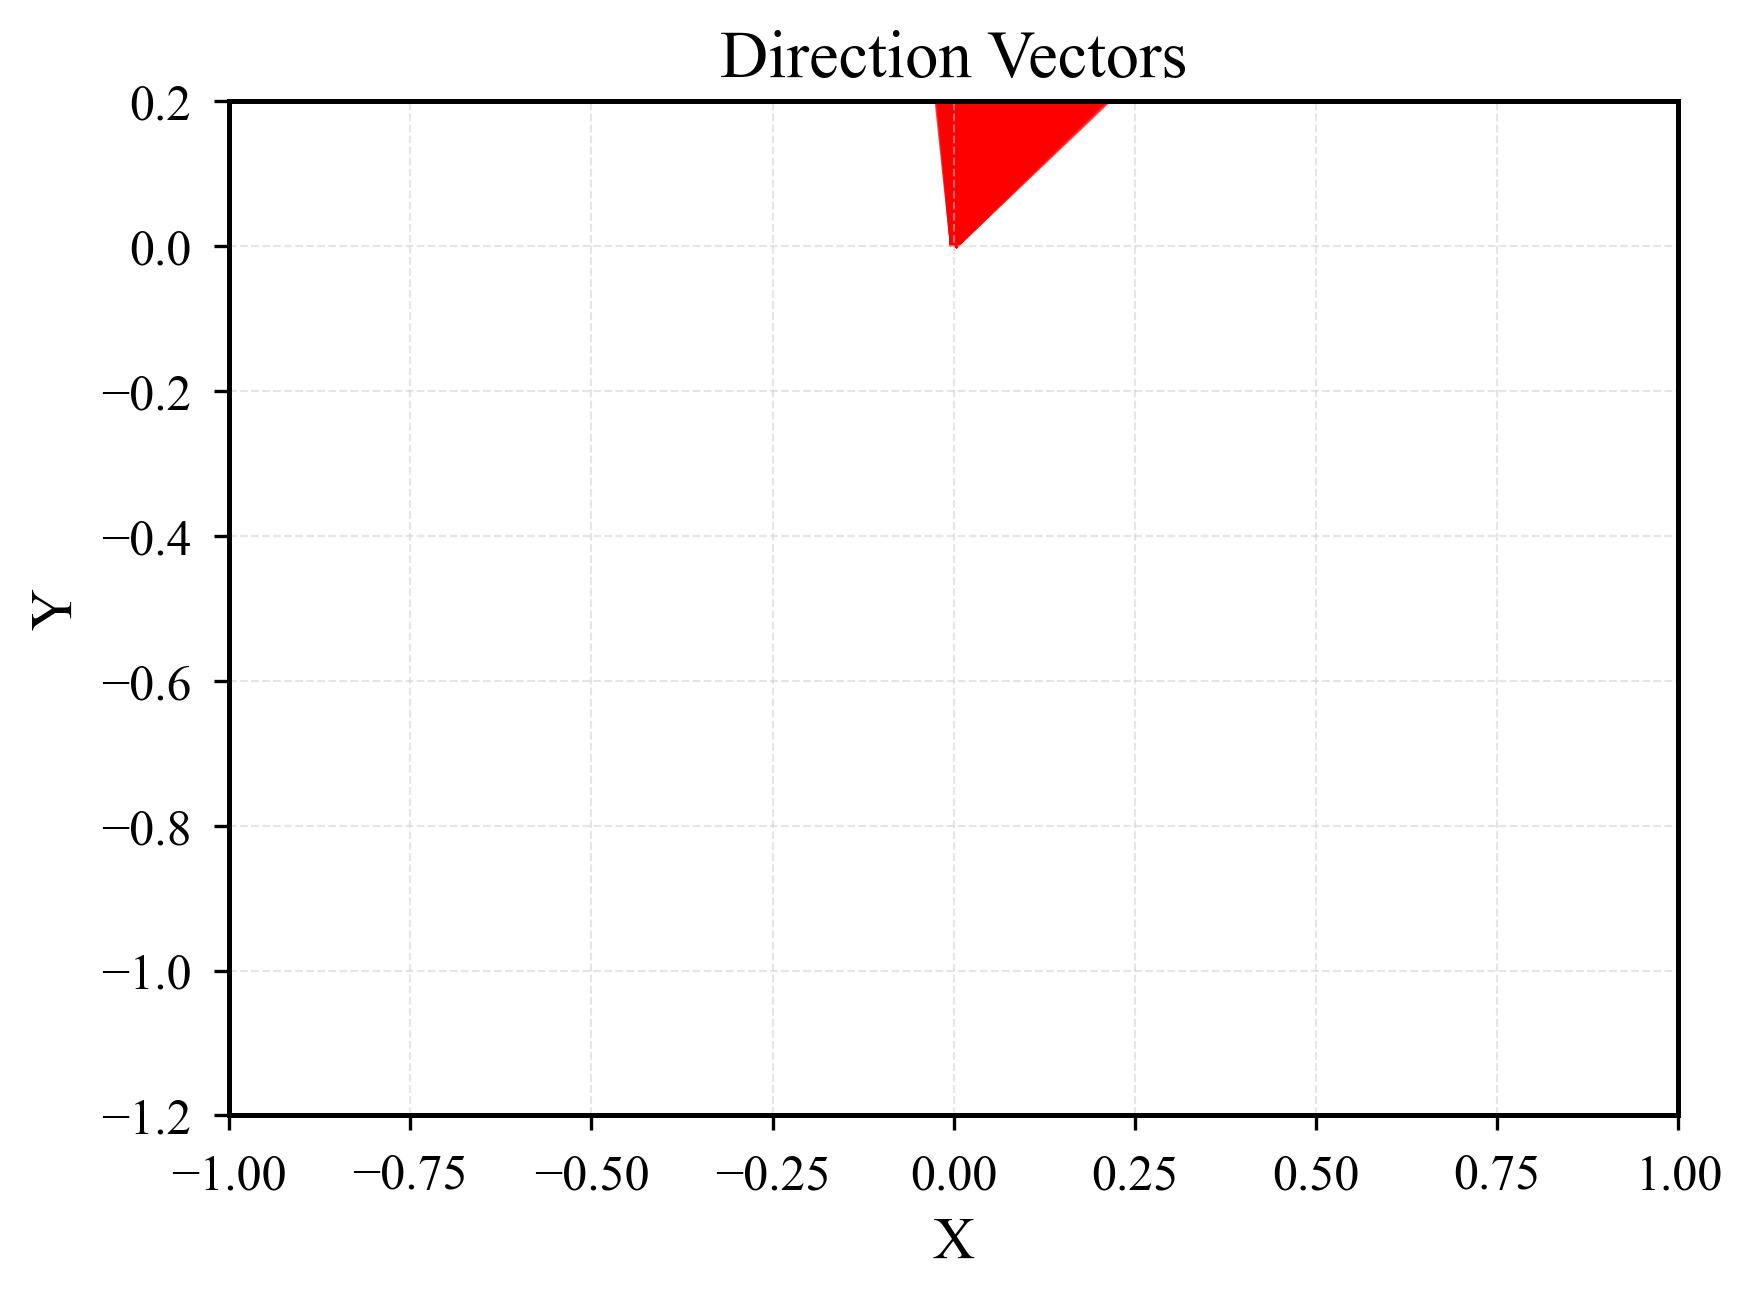

In [84]:
import matplotlib.pyplot as plt
import torch

# If your directions are a torch tensor, convert to numpy
dirs = rotated_directions.numpy() if isinstance(rotated_directions, torch.Tensor) else rotated_directions

# Plot all directions as arrows from (0,0)
plt.figure(figsize=(6, 6))
plt.quiver(
    np.zeros(len(dirs)), np.zeros(len(dirs)),  # X, Y start at origin
    dirs[:, 0], dirs[:, 1],                    # U, V components
    angles='xy', scale_units='xy', scale=1, color='r', alpha=0.7
)
plt.xlim(-1, 1)
plt.ylim(-1.2, 0.2)
plt.gca().set_aspect('equal')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Direction Vectors')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [85]:
rotated_directions

array([[-0.10578606,  0.99438894,  0.        ],
       [-0.09861314,  0.99512583,  0.        ],
       [-0.09143509,  0.99581105,  0.        ],
       [-0.08425228,  0.99644446,  0.        ],
       [-0.0770651 ,  0.99702609,  0.        ],
       [-0.06987391,  0.99755585,  0.        ],
       [-0.06267909,  0.99803376,  0.        ],
       [-0.05548101,  0.99845976,  0.        ],
       [-0.04828004,  0.99883384,  0.        ],
       [-0.04107657,  0.999156  ,  0.        ],
       [-0.03387095,  0.99942619,  0.        ],
       [-0.02666358,  0.99964446,  0.        ],
       [-0.01945482,  0.99981076,  0.        ],
       [-0.01224505,  0.99992502,  0.        ],
       [-0.00503464,  0.9999873 ,  0.        ],
       [ 0.00217603,  0.99999762,  0.        ],
       [ 0.00938658,  0.99995595,  0.        ],
       [ 0.01659665,  0.99986225,  0.        ],
       [ 0.02380586,  0.99971658,  0.        ],
       [ 0.03101382,  0.99951893,  0.        ],
       [ 0.03822018,  0.99926937,  0.   

C:\Users\g630d\AppData\Local\Temp\ipykernel_40296\2288622582.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

C:\Users\g630d\AppData\Local\Temp\ipykernel_40296\2288622582.py:5: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



[INFO] Tracing rays with source: tensor([290.1414,  68.1002, 130.0000], dtype=torch.float64) and directions shape: torch.Size([128, 1, 3])
[INFO] Visualizing sampled points in 3D volume
[INFO] Variances: x=3269.3208, y=1539.9407, z=0.0000


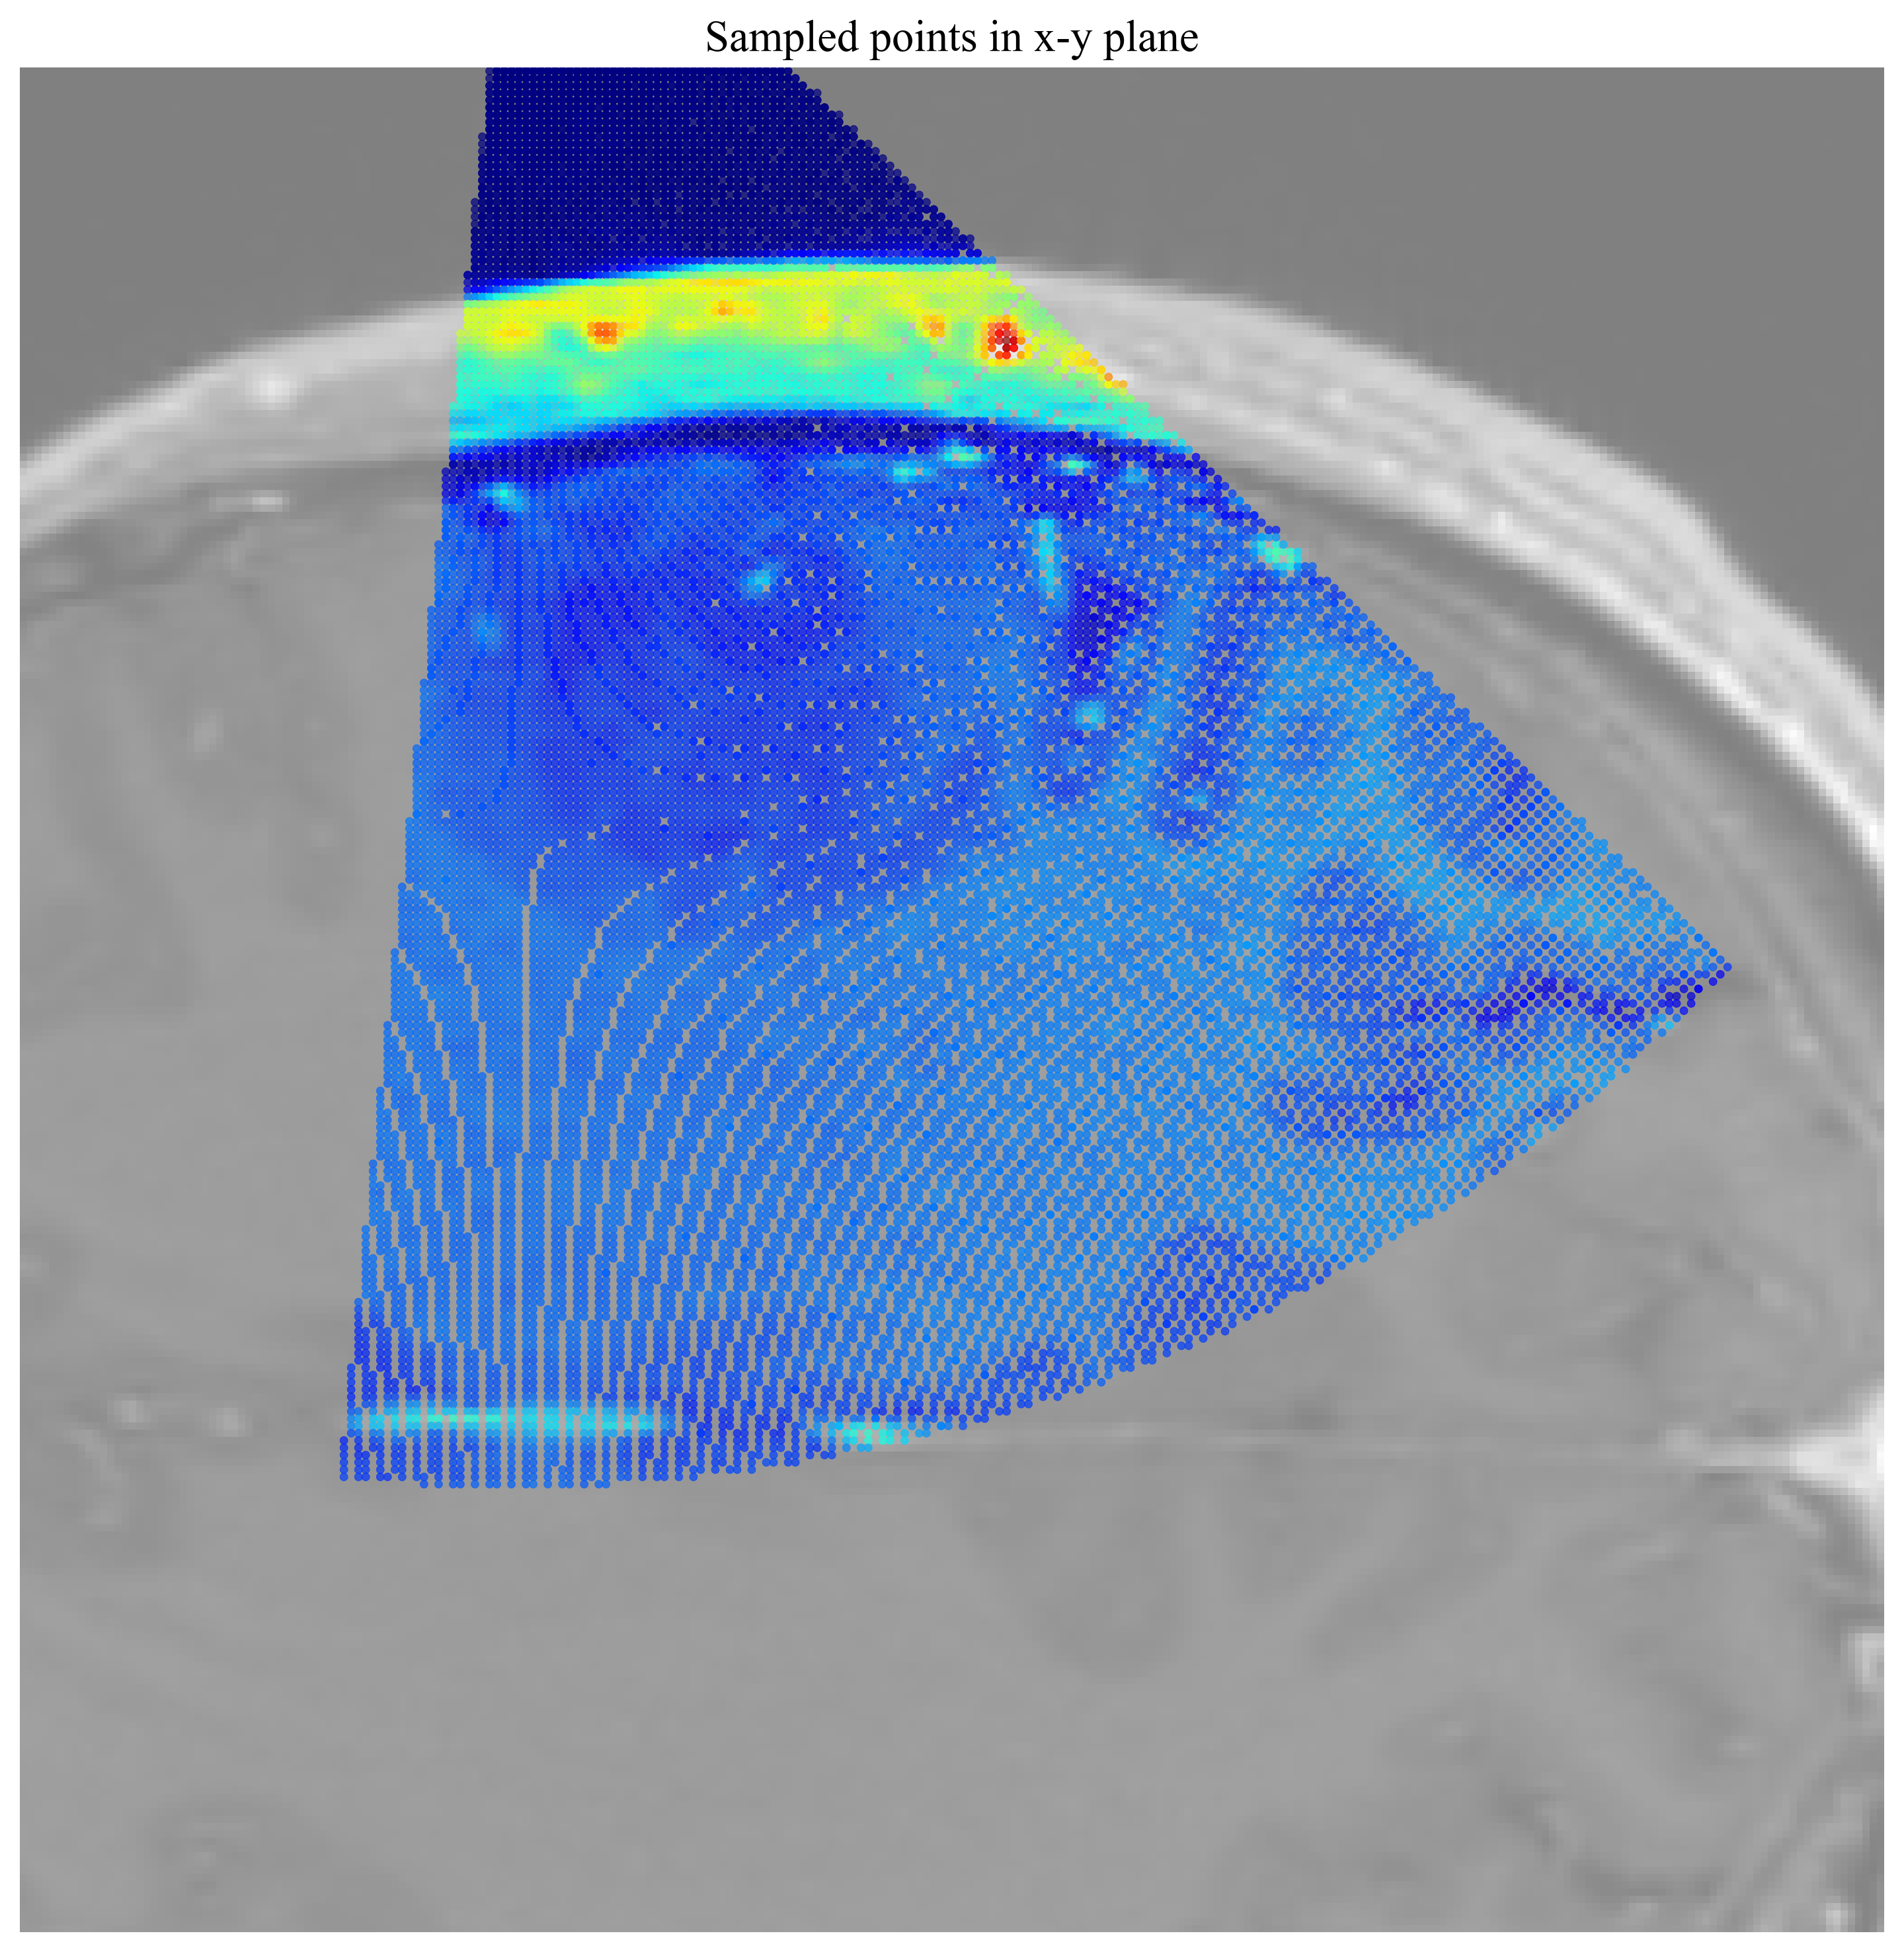

[INFO] Ray values shape: torch.Size([128, 230])
[INFO] Starting from sample index: 115 (for instance, to skip bones)
[INFO] Padded output to start from sample index: 115 torch.Size([128, 231])


In [102]:
renderer = UltrasoundRenderer(num_samples=d2, attenuation_coeff=0.0001)
x,y, z,intensities = renderer.plot_beam_frame(
            volume=torch.tensor(Z_vol),
            source=torch.tensor(apex_mri_world)[[1,0,2]],
            directions=torch.tensor(directions)[:,[1,0,2]],
            angle=0,
            plot=False,
            artifacts=False,
            start=start
        )

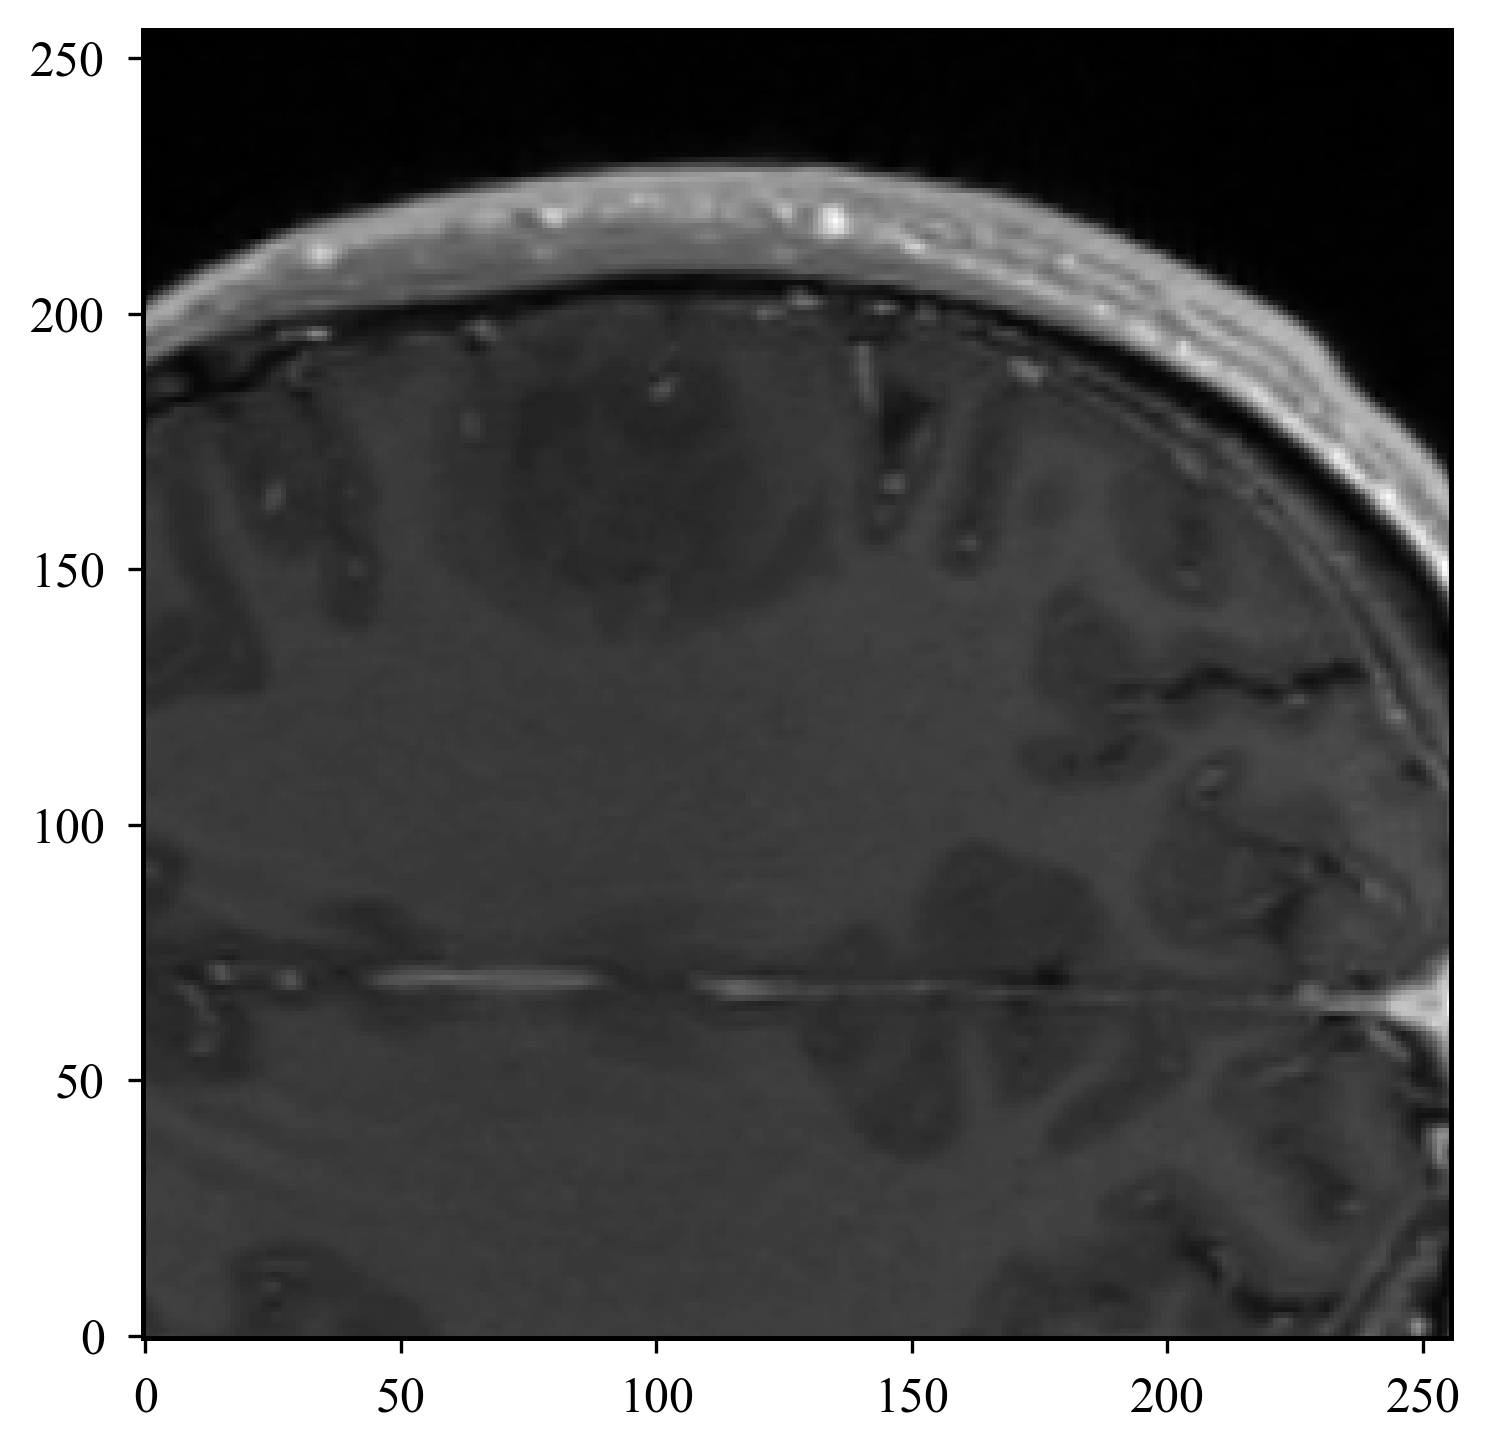

In [111]:
plt.imshow(T1_vol[:,:,130], cmap='gray', origin='lower')


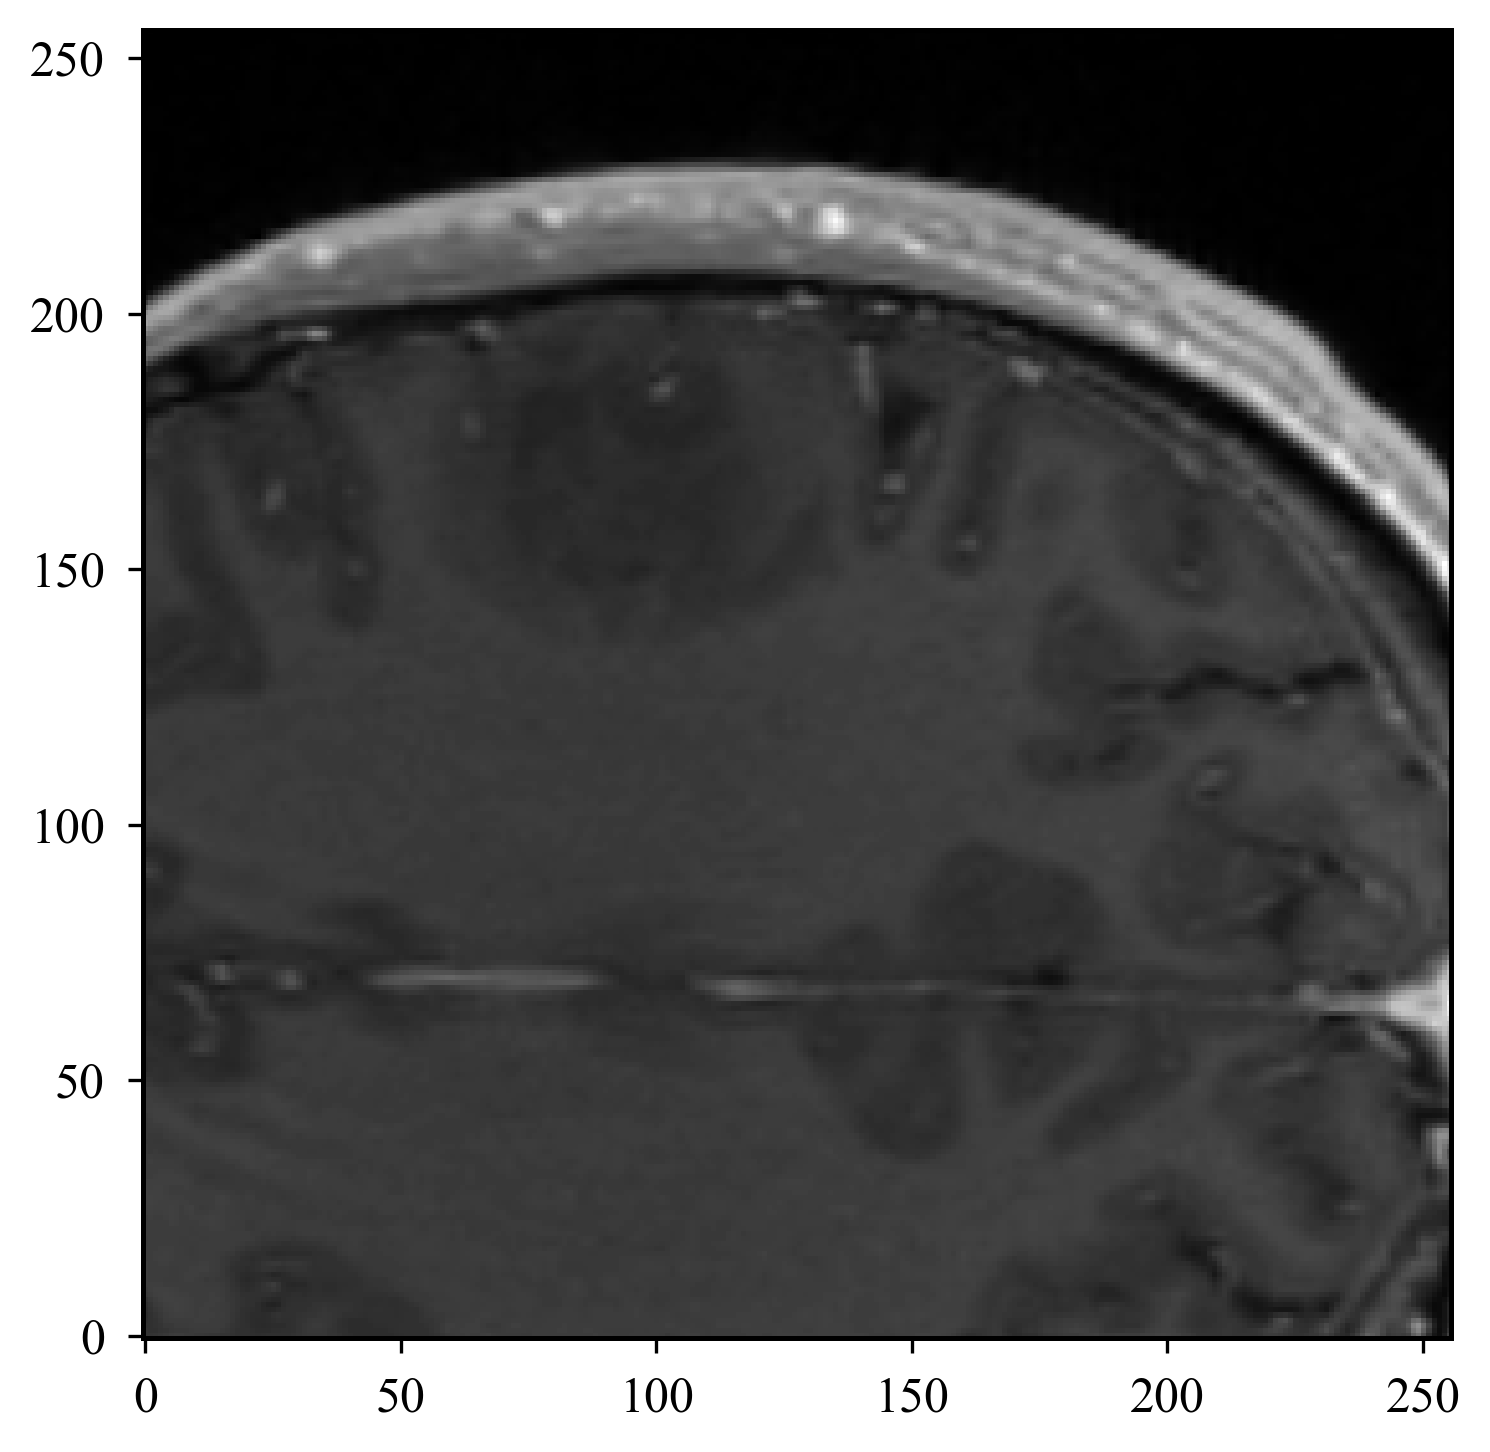

In [112]:
plt.imshow(Z_vol[:,:,130], cmap='gray', origin='lower')

[INFO] Variances: [1179.3038330078125, 1965.274169921875, 0.0]


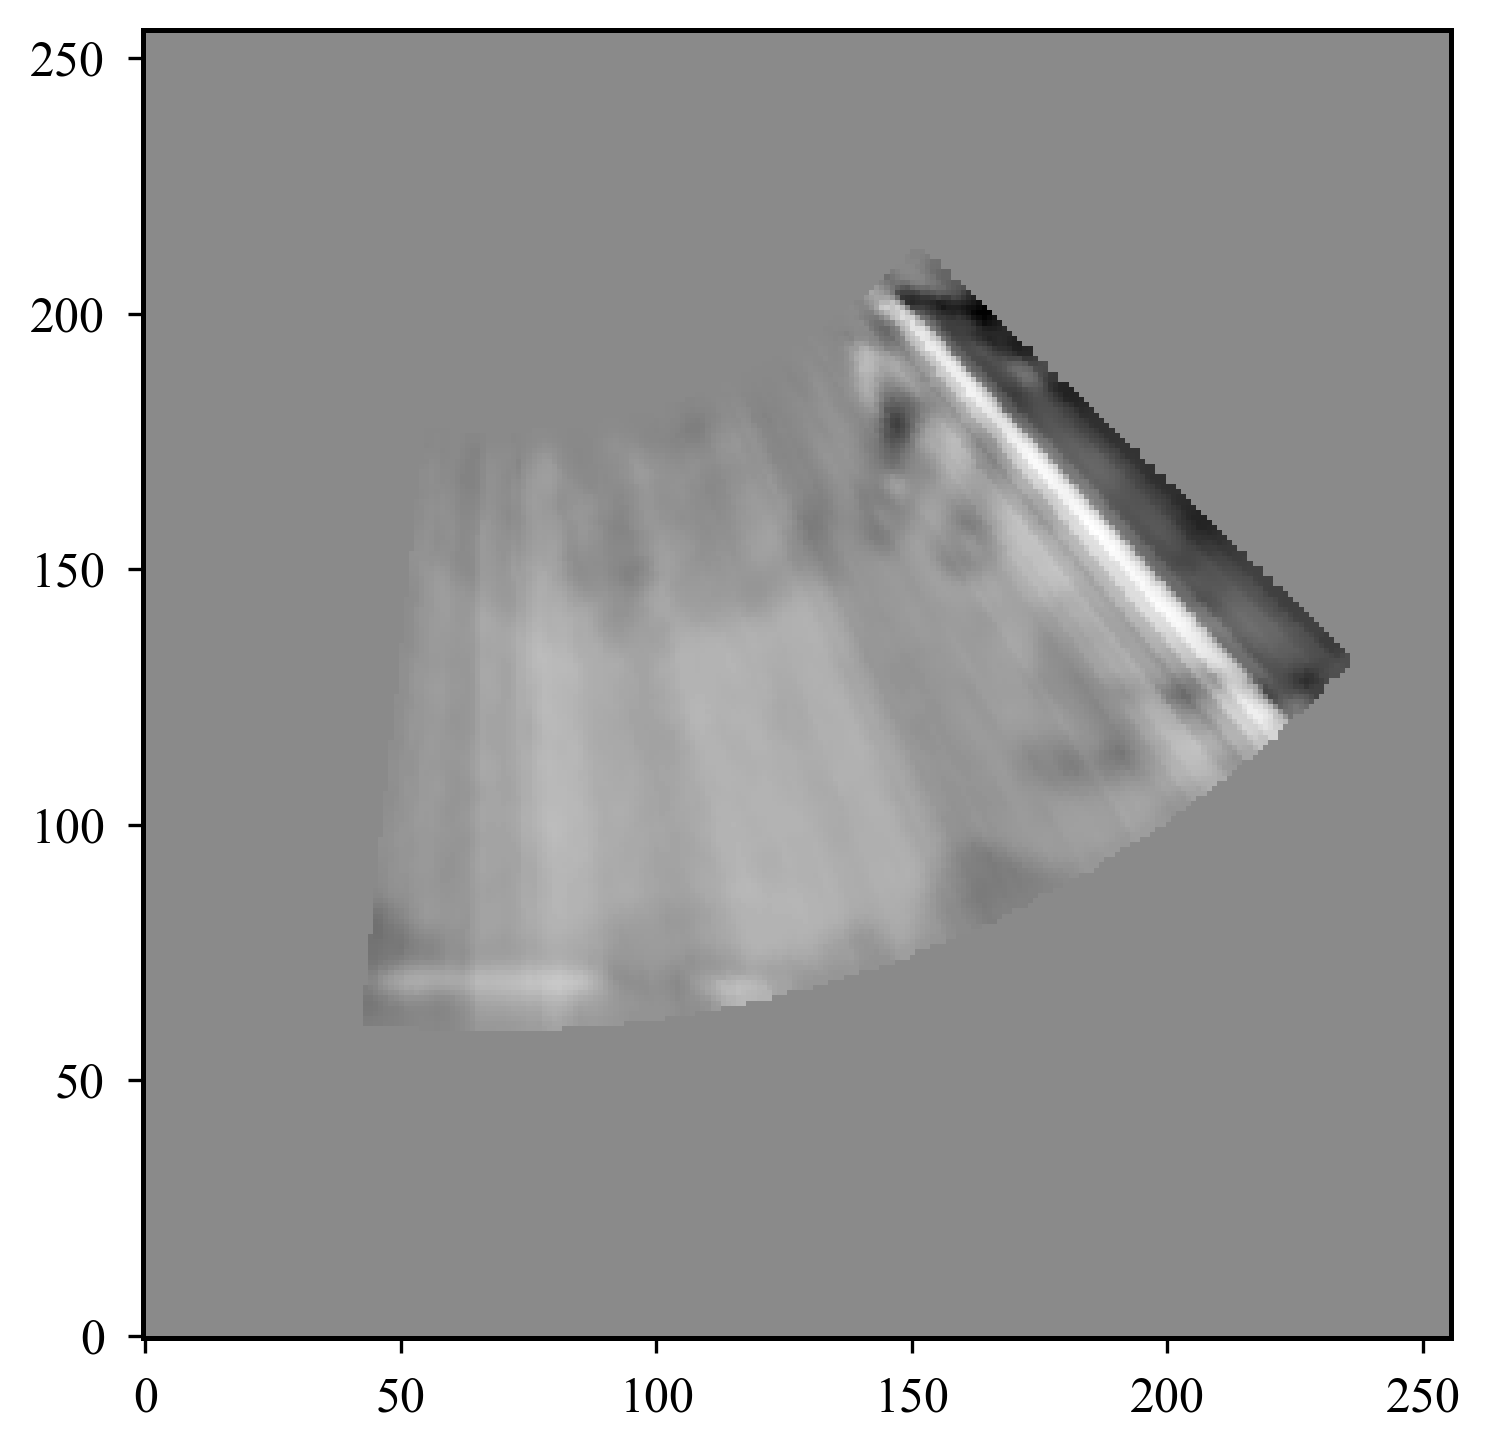

In [113]:
H, W, D = Z_vol.shape
synth_img = differentiable_splat(x, y, z, intensities=intensities[:,:-1], H=H, W=W, sigma=0.5)
plt.imshow(-synth_img.T, cmap='gray', origin="lower")

[INFO] Variances: [1965.274169921875, 1179.3038330078125, 0.0]


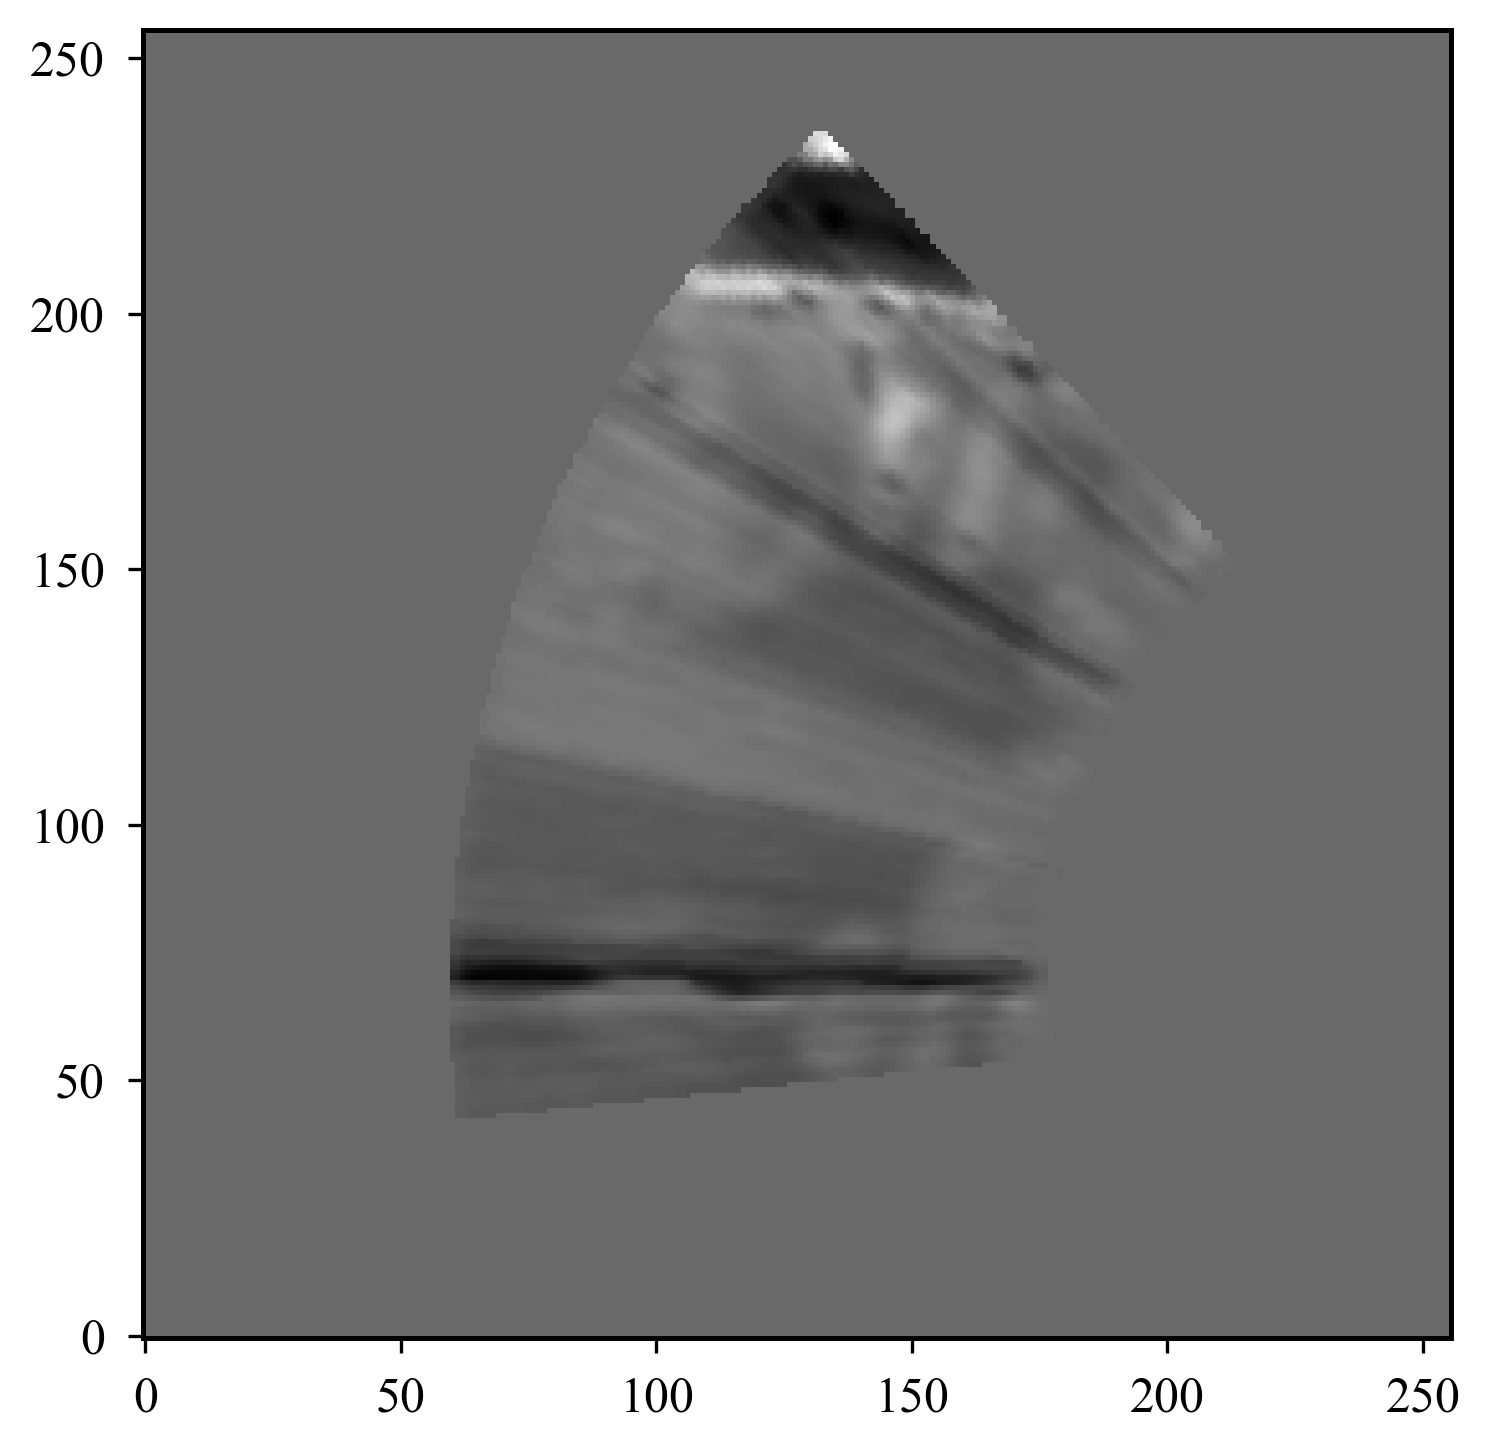

In [71]:
H, W, D = Z_vol.shape
synth_img = differentiable_splat(x, y, z, intensities=intensities[:,:-1], H=H, W=W, sigma=0.5)
plt.imshow(synth_img, cmap='gray', origin="lower")

[INFO] Variances: [1965.274169921875, 1179.3038330078125, 0.0]


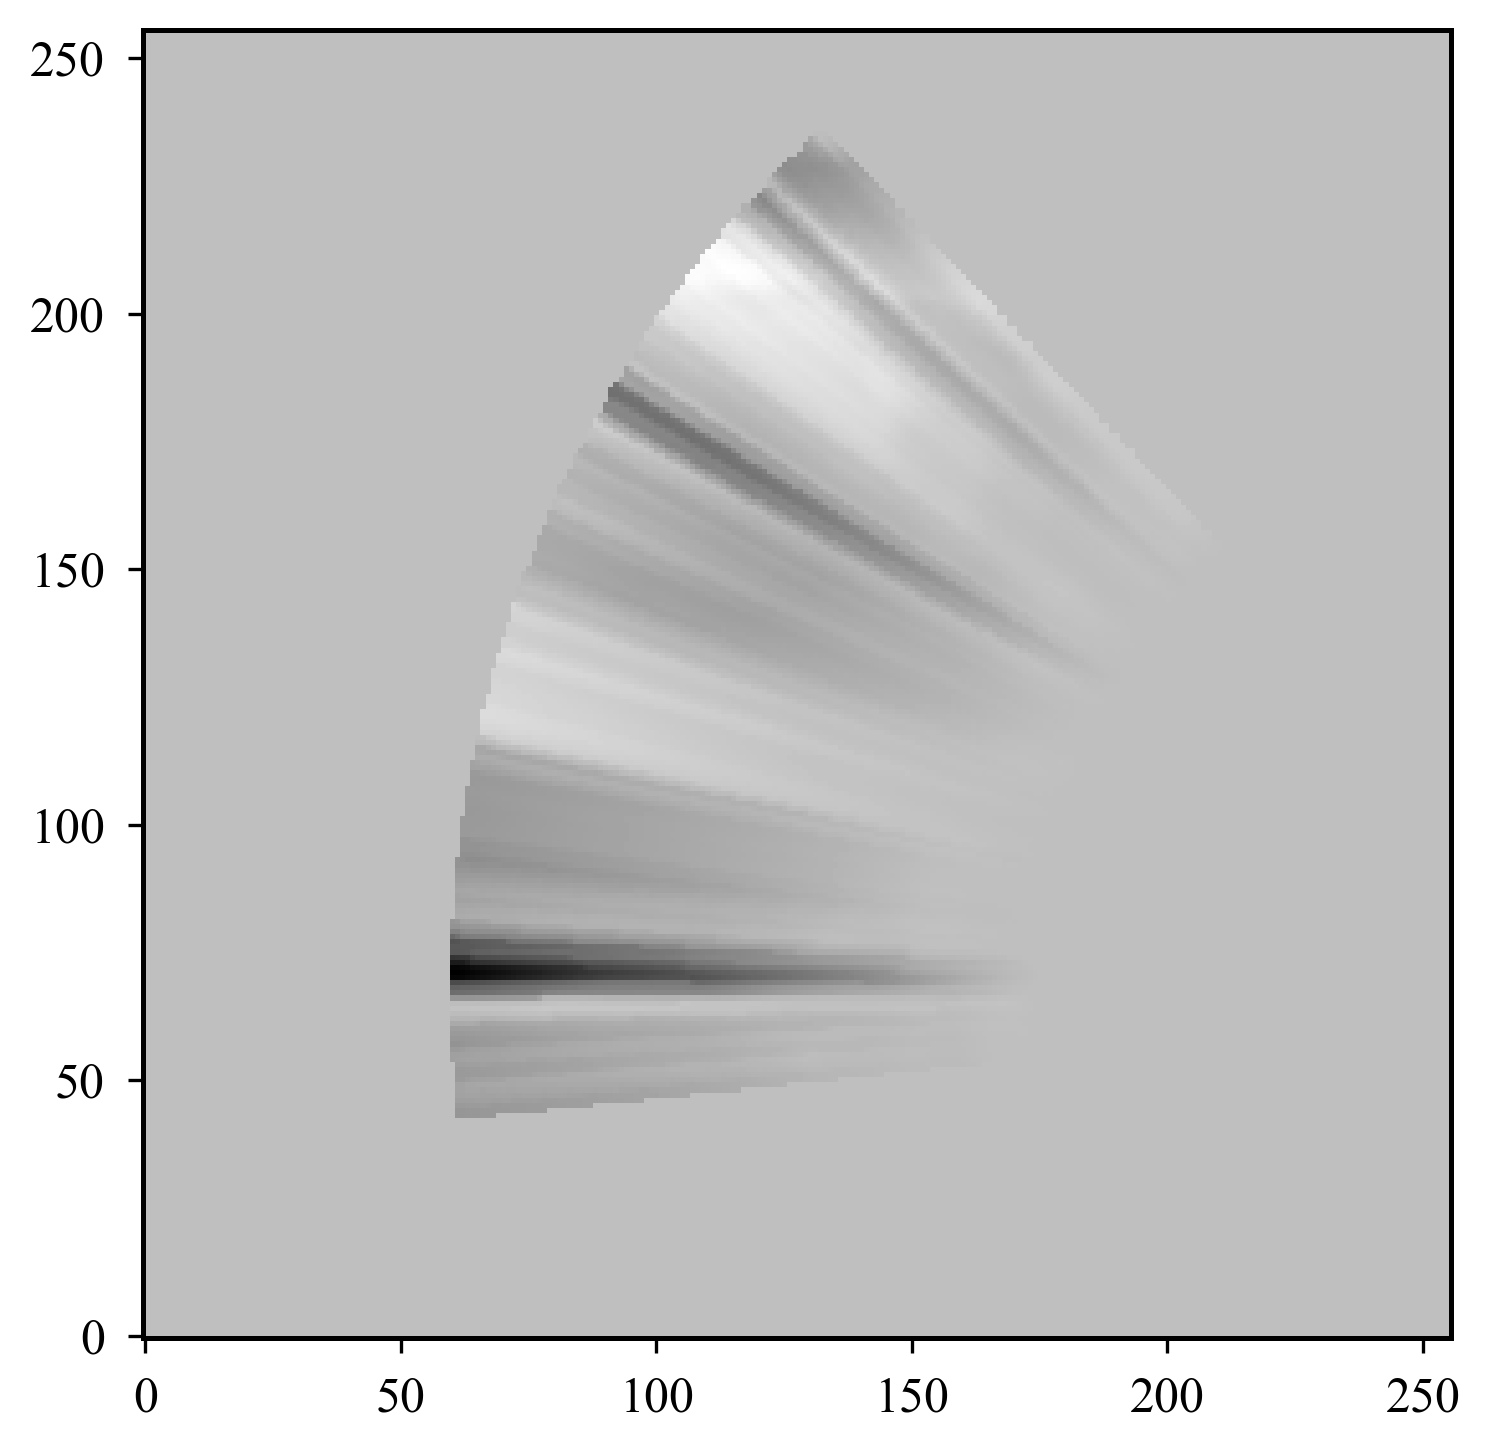

In [75]:
H, W, D = Z_vol.shape
synth_img = differentiable_splat(x, y, z, intensities=intensities[:,:-1], H=H, W=W, sigma=0.5)
plt.imshow(synth_img, cmap='gray', origin="lower")

## Plotting the results

The code below corrects the direction and orientation.

cpu torch.Size([256, 256])
cpu torch.Size([256, 256])
cpu
[INFO] Tracing rays with source: tensor([ 68.1002, 290.1414, 130.0000], dtype=torch.float64) and directions shape: torch.Size([64, 1, 3])
[INFO] Starting from sample index: 110 (for instance, to skip bones)
[INFO] Padded output to start from sample index: 110 torch.Size([64, 229])


C:\Users\g630d\AppData\Local\Temp\ipykernel_28972\2970305400.py:23: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

C:\Users\g630d\AppData\Local\Temp\ipykernel_28972\2970305400.py:24: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

C:\Users\g630d\AppData\Local\Temp\ipykernel_28972\2970305400.py:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Recomputing Impedance Volume


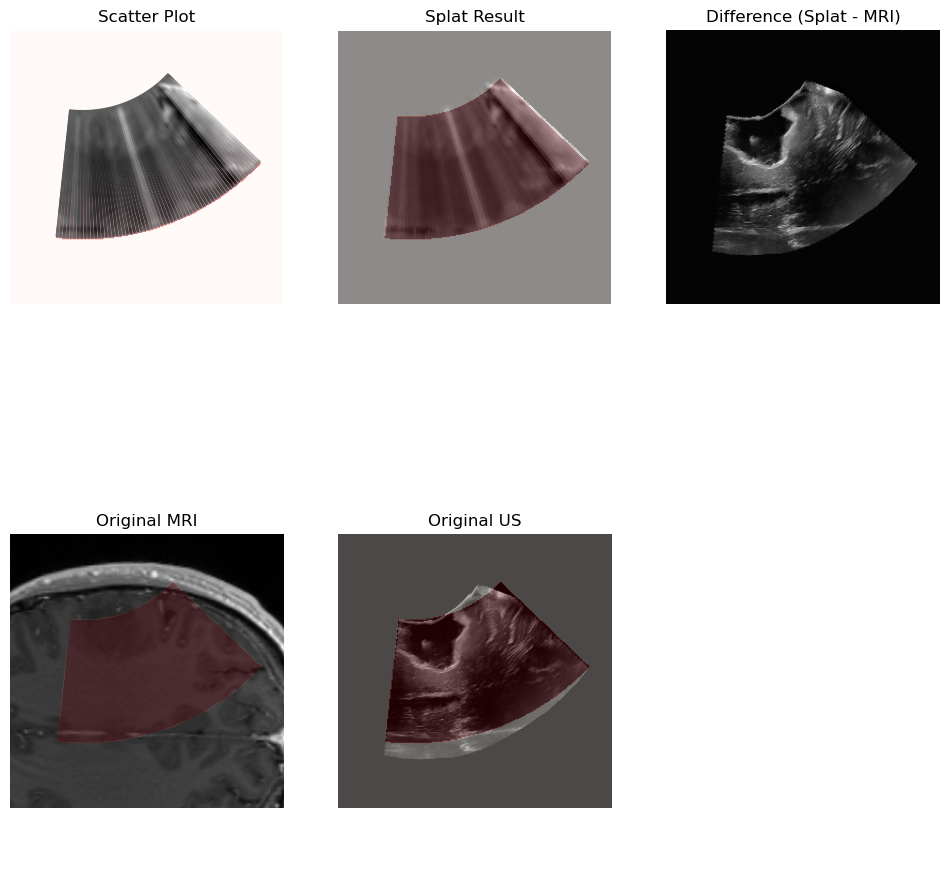

In [28]:
out_2 = model_one.training_forward(
    renderer=renderer_one,
    x=torch.Tensor(T1_vol),
    source=torch.tensor(apex_mri_world),
    directions=directions.flip(0),
    angle=np.degrees(opening_angle)/2,
    start=110
)

x,z, intensities = out_2
import torch

x = x.float().detach().cpu()
z = z.float().detach().cpu()
# apex = torch.tensor(apex_mri_world[:2], dtype=torch.float32)
# median = torch.tensor([-0.3, -0.9], dtype=torch.float32)
intensities = intensities.float().detach().cpu()

# x,z = rotate_around_apex(x, 
#                                   z, 
#                                   apex=apex,
#                                   median=median)
final_image = differentiable_splat(torch.tensor(x), 
                                   torch.tensor(z), 
                                   torch.tensor(intensities), H=256, W=256, sigma=0.5)
# Compare scatter to splat
fig, ax = plt.subplots(2, 3, figsize=(12, 12))

# Scatter Plot
ax[0, 0].scatter(x, z, c=intensities, s=1, cmap='gray')
ax[0, 0].imshow(mask_segment_mri, alpha=0.5, origin='lower', cmap='Reds')
ax[0, 0].set_facecolor('black')
ax[0, 0].set_title("Scatter Plot")
ax[0, 0].set_xlim(0, 256)
ax[0, 0].set_ylim(0, 256)

# Splat Result
ax[0, 1].imshow(final_image, cmap='gray', origin='lower')
ax[0, 1].imshow(mask_segment_mri, alpha=0.3, origin='lower', cmap='Reds')
ax[0, 1].set_title("Splat Result")
ax[0, 1].set_xlim(0, 256)
ax[0, 1].set_ylim(0, 256)

# Original MRI
ax[1, 0].imshow(t1_slice, cmap='gray', origin='lower')
ax[1, 0].imshow(mask_segment_mri, cmap='Reds', alpha=0.3 * (mask_segment_mri > 0).astype(float), origin='lower')
ax[1, 0].set_title("Original MRI")

# Original US
ax[1, 1].imshow(us_slice, cmap='gray', origin='lower')
ax[1, 1].imshow(mask_segment_us, cmap='Reds', alpha=0.3, origin='lower')
ax[1, 1].set_title("Original US")

# Difference
rel_diff = np.abs(final_image/(final_image.max()-final_image.min()) - us_slice/(us_slice.max()-us_slice.min()))
ax[0, 2].imshow(-final_image + us_slice, cmap='gray', origin='lower')
ax[0, 2].set_title("Difference (Splat - MRI)")

# Recomputed Impedance_Vol
print("Recomputing Impedance Volume")
# Z_vol = model_one.forward(torch.tensor(T1_vol, dtype=torch.float32)).detach().numpy()
for a in ax.flat:
    a.axis('off')
plt.show()

# del x, z, intensities, final_image, out_2
torch.cuda.empty_cache()

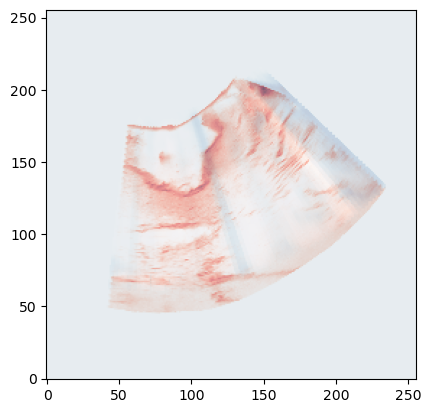

In [26]:
plt.imshow(final_image, origin='lower', cmap='Blues', alpha=0.5, )
plt.imshow(us_slice, origin='lower', cmap='Reds', alpha=0.5)

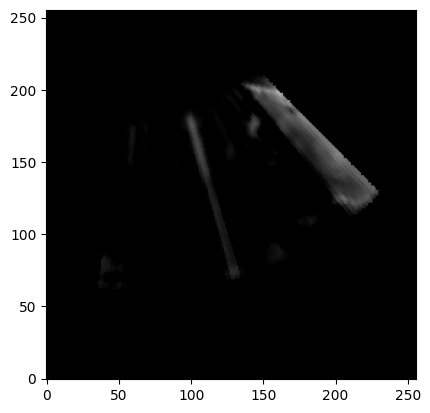

In [ ]:
# out_2 = renderer.plot_beam_frame(
#     volume=torch.tensor(Z_vol),
#     source=source,
#     directions=directions,
#     angle=np.degrees(opening_angle)/2,
#     plot=False,
#     artifacts=False,
#     start=110
# )
# x,z = rotate_around_apex(out_2[0], 
#                         out_2[1], 
#                         apex=apex_mri_world[:2],
#                         median=[-0.3,-0.9])
img = differentiable_splat(x, z, out_2[2], H=256, W=256, sigma=0.5)
plt.imshow(img.detach().numpy(), cmap='gray', vmin=0, vmax=intensities.max()*1.5, origin='lower')


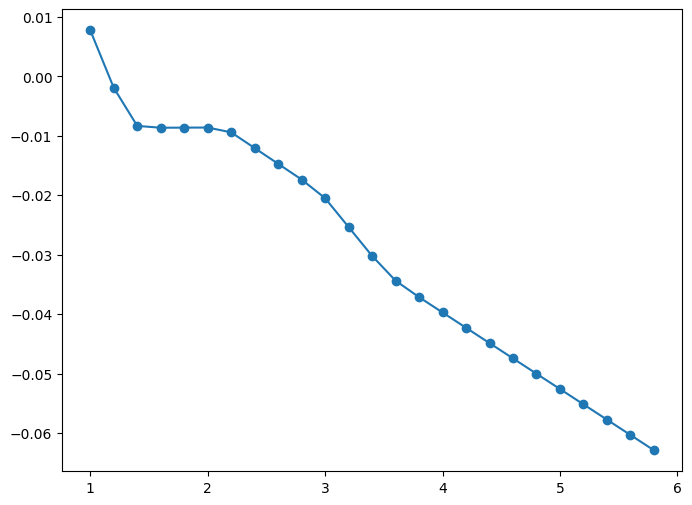

In [ ]:
x = torch.arange(1, 6, step=0.2,dtype=torch.float32).reshape(-1, 1)
y = model_one.forward(x).detach()

plt.figure(figsize=(8, 6))
plt.plot(x.numpy(), y, marker='o', label='Predicted Impedance')